In [36]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from qec_generator import CircuitParams
from simulate_qec_rounds_stim import experiment_run_apt
from stim_lib.scheduled_circuit import generate_scheduled
from scipy.optimize import curve_fit

When we set the number of rounds as the multiple of the distance, we get a nice threshold behavior:

In [42]:
def log_err_fit(rounds, e_logical):
    return 0.5*(1 - (1-2*e_logical)**rounds)


In [53]:
log_err_fit(rounds_vec, 1)

array([0., 0., 0., 0., 0.])

  0%|          | 0/10 [00:00<?, ?it/s]

starting distance = 3


  0%|          | 0/10 [00:00<?, ?it/s]

starting distance = 5


  0%|          | 0/10 [00:00<?, ?it/s]

starting distance = 7


100%|██████████| 10/10 [26:51<00:00, 161.12s/it]


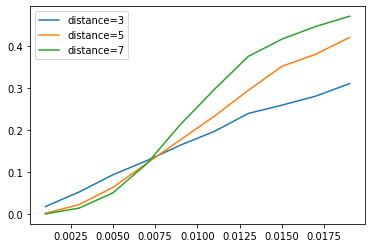

In [20]:


distance_vec = [3, 5, 7]
rounds_vec = np.arange(2, 20, 4)
e_vec = np.arange(1e-3, 2e-2, 2e-3)
success_rate = []



task = 'surface_code:rotated_memory_z'  # looks ok
# task = 'surface_code:unrotated_memory_z'  # looks ok

for distance in distance_vec:
    success_rate.append([])
    print(f'starting distance = {distance}')
    for e in tqdm(e_vec):
        cparams = CircuitParams(t1=20e5,
                        t2=10e5,
                        single_qubit_gate_duration=20,
                        two_qubit_gate_duration=100,
                        single_qubit_depolarization_rate=1e-3,
                        two_qubit_depolarization_rate=e,
                        meas_duration=600,
                        reset_duration=300,
                        reset_latency=40)
        
        circ, cont = generate_scheduled(
            code_task='surface_code:rotated_memory_z',  # looks ok
            distance=distance,
            rounds=3 * distance,
            params=cparams
        )
        success_rate[-1].append(experiment_run_apt(circ, cont, shots=5000))

success_rate = np.array(success_rate)
for i, distance in enumerate(distance_vec):
    plt.plot(e_vec, 1 - success_rate[i], label=f'distance={distance}')
plt.legend()
plt.show()


But what happens when we take a constant number of rounds? Here it looks like the behavior makes no sense!

  0%|          | 0/10 [00:00<?, ?it/s]

starting distance = 3


  0%|          | 0/10 [00:00<?, ?it/s]

starting distance = 5


  0%|          | 0/10 [00:00<?, ?it/s]

starting distance = 7


100%|██████████| 10/10 [10:02<00:00, 60.23s/it]


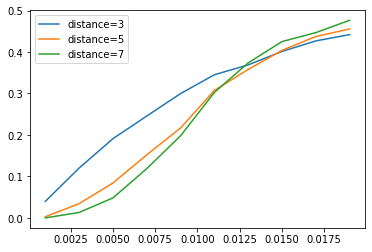

In [21]:


distance_vec = [3, 5, 7]
rounds_vec = np.arange(2, 20, 4)
e_vec = np.arange(1e-3, 2e-2, 2e-3)
success_rate = []



task = 'surface_code:rotated_memory_z'  # looks ok
# task = 'surface_code:unrotated_memory_z'  # looks ok

for distance in distance_vec:
    success_rate.append([])
    print(f'starting distance = {distance}')
    for e in tqdm(e_vec):
        cparams = CircuitParams(t1=20e5,
                        t2=10e5,
                        single_qubit_gate_duration=20,
                        two_qubit_gate_duration=100,
                        single_qubit_depolarization_rate=1e-3,
                        two_qubit_depolarization_rate=e,
                        meas_duration=600,
                        reset_duration=300,
                        reset_latency=40)
        
        circ, cont = generate_scheduled(
            code_task='surface_code:rotated_memory_z',  # looks ok
            distance=distance,
            rounds=20,
            params=cparams
        )
        success_rate[-1].append(experiment_run_apt(circ, cont, shots=5000))

success_rate = np.array(success_rate)
for i, distance in enumerate(distance_vec):
    plt.plot(e_vec, 1 - success_rate[i], label=f'distance={distance}')
plt.legend()
plt.show()


Let's do it as a function of number of rounds, where we are below the threshold:

  0%|          | 0/5 [00:00<?, ?it/s]

starting distance = 3


  0%|          | 0/5 [00:00<?, ?it/s]

starting distance = 5


  0%|          | 0/5 [00:00<?, ?it/s]

starting distance = 7


100%|██████████| 5/5 [00:28<00:00,  5.60s/it]


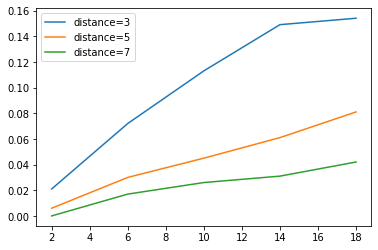

In [32]:


distance_vec = [3, 5, 7]
rounds_vec = np.arange(2, 20, 4)
e_vec = np.arange(1e-3, 2e-2, 2e-3)
success_rate = []



task = 'surface_code:rotated_memory_z'  # looks ok
# task = 'surface_code:unrotated_memory_z'  # looks ok

for distance in distance_vec:
    success_rate.append([])
    print(f'starting distance = {distance}')
    for rounds in tqdm(rounds_vec):
        cparams = CircuitParams(t1=20e5,
                        t2=10e5,
                        single_qubit_gate_duration=20,
                        two_qubit_gate_duration=100,
                        single_qubit_depolarization_rate=1e-3,
                        two_qubit_depolarization_rate=5e-3,
                        meas_duration=600,
                        reset_duration=300,
                        reset_latency=40)
        
        circ, cont = generate_scheduled(
            code_task='surface_code:rotated_memory_z',  # looks ok
            distance=distance,
            rounds=rounds,
            params=cparams
        )
        success_rate[-1].append(experiment_run_apt(circ, cont, shots=1000))

success_rate = np.array(success_rate)
for i, distance in enumerate(distance_vec):
    plt.plot(rounds_vec, 1 - success_rate[i], label=f'distance={distance}')
plt.legend()
plt.show()


And now let's do it with realstic error numbers and a long reset duration:

  0%|          | 0/5 [00:00<?, ?it/s]

starting distance = 3


  0%|          | 0/5 [00:00<?, ?it/s]

starting distance = 5


  0%|          | 0/5 [00:00<?, ?it/s]

starting distance = 7


100%|██████████| 5/5 [00:31<00:00,  6.33s/it]


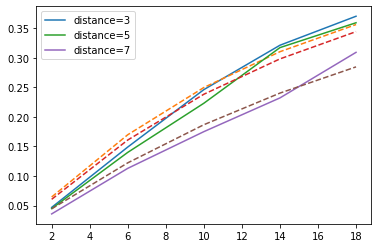

logical_error = [(3, array([0.03340323])), (5, array([0.03132984])), (7, array([0.02283587]))]
1/lambda=[0.93792859]


In [57]:

distance_vec = [3, 5, 7]
rounds_vec = np.arange(2, 20, 4)
e_vec = np.arange(1e-3, 2e-2, 2e-3)
success_rate = []



task = 'surface_code:rotated_memory_z'  # looks ok
# task = 'surface_code:unrotated_memory_z'  # looks ok

for distance in distance_vec:
    success_rate.append([])
    print(f'starting distance = {distance}')
    for rounds in tqdm(rounds_vec):
        cparams = CircuitParams(t1=20e3,
                        t2=10e3,
                        single_qubit_gate_duration=20,
                        two_qubit_gate_duration=100,
                        single_qubit_depolarization_rate=1e-3,
                        two_qubit_depolarization_rate=5e-3,
                        meas_duration=600,
                        reset_duration=300,
                        reset_latency=40)
        
        circ, cont = generate_scheduled(
            code_task='surface_code:rotated_memory_z',  # looks ok
            distance=distance,
            rounds=rounds,
            params=cparams
        )
        success_rate[-1].append(experiment_run_apt(circ, cont, shots=1000))

e_log_vec = []
success_rate_long_reset = np.array(success_rate)
for i, distance in enumerate(distance_vec):
    plt.plot(rounds_vec, 1 - success_rate_long_reset[i], label=f'distance={distance}')
    log_err, pcov = curve_fit(log_err_fit, rounds_vec, 1 - success_rate_long_reset[i], p0=0)
    plt.plot(rounds_vec, log_err_fit(rounds_vec, log_err), '--')
    e_log_vec.append(log_err)
plt.legend()
plt.show()
print(f'logical_error = {[(d, e) for d, e in zip(distance_vec, e_log_vec)]}')
print(f'1/lambda={e_log_vec[1] / e_log_vec[0]}')

And short reset duration:

 20%|██        | 1/5 [00:00<00:02,  1.62it/s]

starting distance = 3


  0%|          | 0/5 [00:00<?, ?it/s]

starting distance = 5


  0%|          | 0/5 [00:00<?, ?it/s]

starting distance = 7


100%|██████████| 5/5 [00:30<00:00,  6.13s/it]


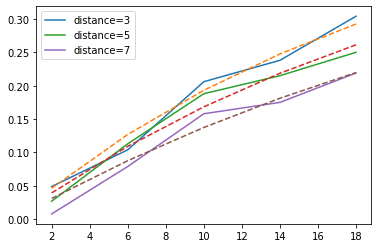

logical_error = [(3, array([0.02382441])), (5, array([0.02011586])), (7, array([0.01581899]))]
1/lambda=[0.84433799]


In [58]:

distance_vec = [3, 5, 7]
rounds_vec = np.arange(2, 20, 4)
e_vec = np.arange(1e-3, 2e-2, 2e-3)
success_rate = []



task = 'surface_code:rotated_memory_z'  # looks ok
# task = 'surface_code:unrotated_memory_z'  # looks ok

for distance in distance_vec:
    success_rate.append([])
    print(f'starting distance = {distance}')
    for rounds in tqdm(rounds_vec):
        cparams = CircuitParams(t1=20e3,
                        t2=10e3,
                        single_qubit_gate_duration=20,
                        two_qubit_gate_duration=100,
                        single_qubit_depolarization_rate=1e-3,
                        two_qubit_depolarization_rate=5e-3,
                        meas_duration=600,
                        reset_duration=20,
                        reset_latency=40)
        
        circ, cont = generate_scheduled(
            code_task='surface_code:rotated_memory_z',  # looks ok
            distance=distance,
            rounds=rounds,
            params=cparams
        )
        success_rate[-1].append(experiment_run_apt(circ, cont, shots=1000))

e_log_vec = []
success_rate_short_reset = np.array(success_rate)
for i, distance in enumerate(distance_vec):
    plt.plot(rounds_vec, 1 - success_rate_short_reset[i], label=f'distance={distance}')
    log_err, pcov = curve_fit(log_err_fit, rounds_vec, 1 - success_rate_short_reset[i], p0=0)
    plt.plot(rounds_vec, log_err_fit(rounds_vec, log_err), '--')
    e_log_vec.append(log_err)
plt.legend()
plt.show()
print(f'logical_error = {[(d, e) for d, e in zip(distance_vec, e_log_vec)]}')
print(f'1/lambda={e_log_vec[1] / e_log_vec[0]}')

Let's get Lambda as a function of the 2 qubit error rate